In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from ordered_set import OrderedSet
import copy 
from statistics import mean
from sklearn.preprocessing import normalize
import pickle
from scipy.stats import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from tqdm import tqdm
from statistics import stdev
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
import pyhsmm
import pyhsmm.internals
import pyhsmm.basic.distributions as distributions

In [3]:
class SemiMarkov():

    def __init__(self):
        pass
 
    def df_col_diff(self, df, columns):
            """Places the difference betweeen to rows of dataframe in a new column named with '_diff' """
            
            df_columns = df.columns

            for col in columns: 
                if col in df_columns:
                    df[col+'_diff'] = df[col].diff()
                else:
                    for column in df_columns:
                        if col in column and column+'_diff' not in df.columns:
                            df[column+'_diff'] = df[column].diff()
            return df

    def transition_matrix(transitions):
        n = 1+ max(transitions) #number of states

        M = [[0]*n for _ in range(n)]

        for (i,j) in zip(transitions,transitions[1:]):
            M[i][j] += 1

        #now convert to probabilities:
        for row in M:
            s = sum(row)
            if s > 0:
                row[:] = [f/s for f in row]
        return M

    
    def save_model(self, model, kappa, iter, fig = 'save'):

        with open('HSMM_Models/{}_{}_{}_{}kap_{}iter.pickle'.format(device_name,feature_names,model_name,kappa, iter),'wb') as outfile:
            pickle.dump(model,outfile,protocol=-1)
            
        fig = plt.figure()
                
        plt.clf()
        model.plot()
        #model.plot_observations()
        #model.plot_stateseq()
        plt.gcf().suptitle('HDP-HSMM for {}_{}_{}_{}kap_{}iter'.format(device_name,feature_names,model_name, kappa, iter)) 
        plt.tight_layout()
        
        
        if fig == 'save':
            plt.savefig('figures/HSMM/{}_{}_{}_{}kap_{}iter.png'.format(device_name,feature_names,model_name, kappa, iter))
        else:
            plt.show()


    def run_HSMM(self, data, features, extra_states = 0, model_count = 4, kappa = 0.05, progprint_xrange_var = 400):


        true_labels= data['state']
        
        states = list(OrderedSet(true_labels)) 
        
        data = data.drop(data.columns[[0,-1]], axis=1)
        
        Nmax = len(states) + extra_states
        
        data = data.reset_index(drop=True)

        #data = normalize(data[['cpu_user_time_diff','cpu_system_time_diff','cpu_idle_time_diff','memory','net_sent_diff']])
        data = data[features].to_numpy() 
        
        obs_dim = len(data[0])
        
        obs_hypparams = {'mu_0':np.zeros(obs_dim),
                'sigma_0':np.eye(obs_dim),
                'kappa_0': kappa,
                'nu_0':obs_dim+10}
                
        dur_hypparams = {'alpha_0':2*10,
                         'beta_0':2}

        distributions.DurationDistribution

        obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]
        dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

        posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
                alpha=6.,gamma=6., # better to sample over these; see concentration-resampling.py
                init_state_concentration=6., # pretty inconsequential
                obs_distns=obs_distns,
                dur_distns=dur_distns)

        posteriormodel.add_data(data)

        models = []
                
        for idx in pyhsmm.pyhsmm.util.text.progprint_xrange(progprint_xrange_var):
            posteriormodel.resample_model()
            if (idx+1) % int(progprint_xrange_var/model_count) == 0:
                models.append(copy.deepcopy(posteriormodel))
                
        model = models[-1]
        return model, model.stateseqs, true_labels, states
    
    
    def get_HSMM_state_seq(self, data, model_path, device_name, model_count = 4, progprint_xrange_var = 400, plot = False):
        
        objects = []
        true_labels = data['state']
        
        with (open(model_path, "rb")) as openfile:
            while True:
                try:
                    objects.append(pickle.load(openfile))
                except EOFError:
                    break

        model = objects[0]
            
        if plot == True:
            model.plot()
            plt.gcf().suptitle('HDP-HSMM for {}'.format(device_name))
            plt.tight_layout()
            plt.show()
            
        return objects[0], objects[0].stateseqs, true_labels
        
    def HSMM_pred(self, model, seed_start, seed_end, pred_window):
        
        global df
        
        obs, stateseq = model.predict(df[seed_start:seed_end],pred_window)
        log_likelihood = model.log_likelihood(obs)

        return obs, stateseq, log_likelihood
    
    def metrics_plots(self, obs, pred_obs, features):# pred_stateseq, labels_running, labels_top_cpu, features):
               
                      
        """
        plt.plot(real_stateseq[0], color = 'red', label = 'states')
        plt.plot(pred_stateseq, color = 'blue', label = 'predicted')
        plt.legend(loc='best')
        plt.grid()
        plt.show()
        """
        obs_dict = {feature:[] for feature in features}
        pred_obs_dict = {feature:[] for feature in features}
        
        results_dict = {}
        
        for pred_ob in pred_obs:
            for feature in features:
                pred_obs_dict[feature].append(pred_ob[features.index(feature)])
                
        for ob in obs:
            for feature in features:
                obs_dict[feature].append(ob[features.index(feature)])
                
        for feature in features:

            results_dict[feature+'_observations'] = obs_dict[feature]
            results_dict[feature+'_predicted_observations'] = pred_obs_dict[feature]
            
            results_dict[feature+'_rmse'] = sqrt(mean_squared_error(obs_dict[feature],pred_obs_dict[feature]))
            results_dict[feature+'_mae'] = mean_absolute_error(obs_dict[feature],pred_obs_dict[feature])


            """state_sequences
            plt.plot(data[feature][test_start_idx:], color = 'red', label = 'obs')
            plt.plot(pred_obs_dict[feature][test_start_idx:], color = 'blue', label = 'predicted')
            plt.title(feature)
            plt.legend(loc='best')
            plt.grid()
            plt.show()
            """
            
        return results_dict 
        
    def merge_datasets(self, save, df_path, dataset_list):

        df = pd.concat(dataset_list)
        
        if save == True:
            df.to_csv(df_path)
            
        return df
    
    def merge_dataset(self, device_name,dataset_name_list, new_name):
        
        prep_data_list = list()
        num_list = ''
        
        for dataset_name in dataset_name_list:
            prep_data_list.append(pd.read_csv('data/{}_res_usage_data_{}.csv'.format(device_name,dataset_name), index_col = 'time_stamp'))
        
        return self.merge_datasets(True, 'data/{}_res_usage_data_{}.csv'.format(device_name, new_name), prep_data_list)

    def preprocess_data(self, device_name, freq, data_name):
        """Preprocessing labeled data"""

        #Read Data, create difference feature, and clean nans
        labeled_data = pd.read_csv(f'data/{device_name}_{freq}MHz_res_usage_data_{data_name}.csv', index_col = 'time_stamp')
        labeled_data = SM.df_col_diff(labeled_data, diff_columns)
        labeled_data = labeled_data.fillna(0)


        #Move label column to the end
        labeled_data_cols = labeled_data.columns.tolist()
        oldindex = labeled_data_cols.index('state')
        labeled_data_cols.insert(len(labeled_data_cols), labeled_data_cols.pop(oldindex))
        labeled_data = labeled_data[labeled_data_cols]
        
        # remove first row due to diff = 0
        labeled_data = labeled_data.iloc[1: , :] 
        # remove rows with tranisition saving data states
        labeled_data = labeled_data[labeled_data['state'] != 'transition']
        labeled_data = labeled_data[labeled_data['state'] != 'saving data']

        # For quick test
        #labeled_data = labeled_data[:2000] #for testing only

        # train/test split        
        labeled_data_train = labeled_data[:int(0.7*len(labeled_data))]
        labeled_data_test = labeled_data[int(0.7*len(labeled_data)):]
        

        return labeled_data_train, labeled_data_test

    def check_duplicate_label(self, dict):
        
        for key1, val1 in dict.items():

            for key2, val2 in dict.items():
                if key1 != key2:
                    if val2 == val1:
                        print('Duplicate labels detected, not saving model')
                        return False
                        
                    else:
                        pass
        return True
        
        
    
    def grid_search(self, extras, kappas, iters, save='save'):
        
        max_accuracy = 0
        best_extra, best_kappa, best_iter = 0, 0, 0

        for extra in extras:
            for kap in kappas:
                for iter in iters:

                    print(f'Training for {extra} extra states, kappa = {kap}, and iters = {iter}')

                    
                    temp_model, temp_statesseqs, temp_true_labels, temp_states = self.run_HSMM(labeled_data_train, features, extra_states = extra, kappa = kap, progprint_xrange_var =iter) 
                    
                    labeled_data_train['predicted'] = temp_statesseqs[0]
                    Labels = {}
                    Accuracies = []

                    for name, _ in labeled_data_train.groupby('state'):
                        print(name)
                        label = labeled_data_train.groupby('state').get_group(name)['predicted'].value_counts(normalize=True)
                        print(label)
                        Labels[name] = label.idxmax()
                        Accuracies.append(label.max())

                    avg_acc = mean(Accuracies)
                    
                    print(Labels)
                    print(f'Accuracies: {Accuracies}')
                    print(f'Average Accuracy = {avg_acc}')

                    if SM.check_duplicate_label(Labels):

                        if avg_acc > max_accuracy:
                
                            max_accuracy = avg_acc
                            best_model, best_state_sequences, best_true_labels, best_states = temp_model, temp_statesseqs, temp_true_labels, temp_states                  
                            best_extra, best_kappa, best_iter = extra, kap, iter
                  
                            print(f'Model saved for {best_extra} extra states, kappa = {best_kappa}, and iters = {best_iter}')
                            self.save_model(best_model, best_kappa, best_iter, save) 

        return best_model, best_state_sequences, best_true_labels, best_states

    def plot_states(self, colors):

        indexes_dict = labeled_data_test.groupby('state').indices
        
        for key in indexes_dict:
            new_list = []
           
            prev_ind = indexes_dict[key][0]
            new_list.append(prev_ind)

            for inds in indexes_dict[key][1:]:
                

                if inds - prev_ind > 1 : # plot backgroud color for new state
                    new_list.append(prev_ind)

                    plt.axvspan(new_list[0],new_list[1], facecolor=colors[key])

                    new_list = []
                    new_list.append(inds)

                if inds == indexes_dict[key][-1]: # plot backgroud color for las state

                    new_list.append(inds)

                    plt.axvspan(new_list[0],new_list[1], facecolor=colors[key])

                prev_ind = inds
    
    def plot_accuracy_likelihood(self, prediction_window, rolling_window):

        print(f"Steps {prediction_window} - MA Window {rolling_window}")
        scaler = MinMaxScaler() 
        accuracy_scaled = scaler.fit_transform(labeled_data_test[f'accuracy - {prediction_window} step'].rolling(rolling_window).mean().values.reshape(-1, 1))
        log_likelihood_scaled = scaler.fit_transform(labeled_data_test[f'log_likelihood - {prediction_window} step'].values.reshape(-1, 1))

        plt.figure(figsize=(12, 8), dpi=80)
        plt.plot(accuracy_scaled, color='black', label='Accuracy')
        plt.plot(log_likelihood_scaled, color='b', label='Log Likelihood')
        
        colors = {'game': 'salmon', 'augmented_reality': 'lightblue', 'idle': 'lightgreen', 'mining': 'peachpuff', 'stream': 'whitesmoke'}
        print(colors)
        self.plot_states(colors)

        plt.legend(loc='best')
        plt.grid()
        plt.show()

    def plot_confusion_matrix(self, confusion_matrix, axes, class_label, class_names, fontsize=14):

        df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

        try:
            heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
        except ValueError:
            raise ValueError("Confusion matrix values must be integers.")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
        axes.set_ylabel('True label')
        axes.set_xlabel('Predicted label')
        axes.set_title(class_label)

    def classification_report(self, confusion_matrix_list, labels):

        fig, ax = plt.subplots(1, 5, figsize=(12, 3))
        
        for axes, cfs_matrix, label in zip(ax.flatten(), np.average(confusion_matrix_list, axis=0), labels):
            
            self.plot_confusion_matrix(np.round(cfs_matrix).astype(int), axes, label, ["T", "F"])

            print(label)
            cfs_matrix = list(cfs_matrix)
            recall = cfs_matrix[0][0] / sum(cfs_matrix[0])
            spcificity = cfs_matrix[1][1] / sum(cfs_matrix[1])
            precision = cfs_matrix[0][0] / (cfs_matrix[0][0] + cfs_matrix[1][0])
            print('Recall', round(recall*100,2))
            print('Specificity', round(spcificity*100,2))
            print('Precision', round(precision*100,2))

            F1 = round(2 * (precision * recall) / (precision + recall),2)
            print('F1', F1)
        
        fig.tight_layout()
        plt.show()

In [4]:
SM = SemiMarkov()

features = ['cpu_user_time_diff','cpu_system_time_diff','cpu_idle_time_diff','memory']#,'net_sent_diff']
diff_columns = ['cpu_user_time', 'cpu_system_time','cpu_idle_time', 'net_sent', 'net_recv', 'io_counters_read_count_', 'io_counters_write_count_', 'io_counters_read_bytes_', 'io_counters_write_bytes_','io_counters_read_chars_', 'io_counters_write_chars_', 'cpu_times_user_','cpu_times_system_', 'cpu_times_children_user_', 'cpu_times_children_system_']

device_name = 'RPi4B8GB'
freq = 1800
feature_names = 'cpu-all_mem'
progprint = 400
#model_count = 4
model_index = 3
model_name = 'rvp_random_48hr_2'

lookback = 300

rmse_dict = {feature+'_rmse':[] for feature in features}
mae_dict = {feature+'_mae':[] for feature in features} 
observations_dict = {feature+'_observations':[] for feature in features}
pred_observations_dict = {feature+'_predicted_observations':[] for feature in features} 
rmse_dict_stat, mae_dict_stat = {}, {}

In [5]:
data_name = model_name
prediction_windows = [1,2,5,10,15,30,60]
labeled_data_train, labeled_data_test = SM.preprocess_data(device_name, freq, data_name)

Training for 2 extra states, kappa = 0.05, and iters = 800
.........................  [  25/800,   73.30sec avg, ETA 15:46:45 ]
.........................  [  50/800,   62.79sec avg, ETA 13:04:49 ]
.........................  [  75/800,   51.29sec avg, ETA 10:19:46 ]
.........................  [ 100/800,   45.74sec avg, ETA 08:53:35 ]
.........................  [ 125/800,   42.50sec avg, ETA 07:58:08 ]
.........................  [ 150/800,   40.18sec avg, ETA 07:15:18 ]
.........................  [ 175/800,   38.59sec avg, ETA 06:41:58 ]
.........................  [ 200/800,   37.49sec avg, ETA 06:14:53 ]
.........................  [ 225/800,   36.71sec avg, ETA 05:51:46 ]
.........................  [ 250/800,   35.92sec avg, ETA 05:29:18 ]
.........................  [ 275/800,   35.42sec avg, ETA 05:09:54 ]
.........................  [ 300/800,   34.90sec avg, ETA 04:50:49 ]
.........................  [ 325/800,   34.54sec avg, ETA 04:33:29 ]
.........................  [ 350/800,   34.2

<Figure size 432x288 with 0 Axes>

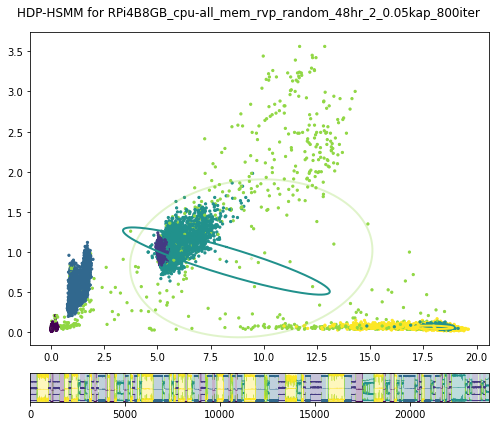

Training for 2 extra states, kappa = 0.05, and iters = 800
.........................  [  25/800,   29.09sec avg, ETA 06:15:45 ]
.........................  [  50/800,   29.02sec avg, ETA 06:02:48 ]
.........................  [  75/800,   29.01sec avg, ETA 05:50:36 ]
.........................  [ 100/800,   28.99sec avg, ETA 05:38:10 ]
.........................  [ 125/800,   28.89sec avg, ETA 05:25:01 ]
.........................  [ 150/800,   29.07sec avg, ETA 05:14:56 ]
.........................  [ 175/800,   29.15sec avg, ETA 05:03:37 ]
.........................  [ 200/800,   29.19sec avg, ETA 04:51:53 ]
.........................  [ 225/800,   29.29sec avg, ETA 04:40:43 ]
.........................  [ 250/800,   29.37sec avg, ETA 04:29:12 ]
.........................  [ 275/800,   29.37sec avg, ETA 04:17:01 ]
.........................  [ 300/800,   29.38sec avg, ETA 04:04:51 ]
.........................  [ 325/800,   29.36sec avg, ETA 03:52:25 ]
.........................  [ 350/800,   29.3

In [6]:
"""Generates HSMM Model using Grid Search"""
model, state_sequences, true_labels, states = SM.grid_search([2], [0.05,0.05,0.1,0.1], [800], "don't save fig")

In [7]:
"""Generates HSMM Model using Grid Search"""
model, state_sequences, true_labels, states = SM.grid_search([2], [0.1,0.1], [800], "don't save fig")

Training for 2 extra states, kappa = 0.1, and iters = 800
.........................  [  25/800,   31.28sec avg, ETA 06:44:01 ]
.........................  [  50/800,   31.00sec avg, ETA 06:27:30 ]
.........................  [  75/800,   30.98sec avg, ETA 06:14:18 ]
.........................  [ 100/800,   30.85sec avg, ETA 05:59:52 ]
.........................  [ 125/800,   30.83sec avg, ETA 05:46:50 ]
.........................  [ 150/800,   30.80sec avg, ETA 05:33:37 ]
.........................  [ 175/800,   30.76sec avg, ETA 05:20:27 ]
.........................  [ 200/800,   30.75sec avg, ETA 05:07:29 ]
.........................  [ 225/800,   30.79sec avg, ETA 04:55:06 ]
.........................  [ 250/800,   30.80sec avg, ETA 04:42:21 ]
.........................  [ 275/800,   30.83sec avg, ETA 04:29:46 ]
.........................  [ 300/800,   30.86sec avg, ETA 04:17:09 ]
.........................  [ 325/800,   30.86sec avg, ETA 04:04:16 ]
.........................  [ 350/800,   30.85

UnboundLocalError: local variable 'best_model' referenced before assignment

In [8]:
"""Generates HSMM Model using Grid Search"""
model, state_sequences, true_labels, states = SM.grid_search([2], [0.1,0.1,0.1], [800], "don't save fig")

Training for 2 extra states, kappa = 0.1, and iters = 800
.........................  [  25/800,   30.63sec avg, ETA 06:35:36 ]
.........................  [  50/800,   30.30sec avg, ETA 06:18:44 ]
.........................  [  75/800,   30.35sec avg, ETA 06:06:44 ]
.........................  [ 100/800,   30.13sec avg, ETA 05:51:33 ]
.........................  [ 125/800,   30.09sec avg, ETA 05:38:29 ]
.........................  [ 150/800,   30.16sec avg, ETA 05:26:44 ]
.........................  [ 175/800,   30.17sec avg, ETA 05:14:14 ]
.........................  [ 200/800,   30.18sec avg, ETA 05:01:49 ]
.........................  [ 225/800,   30.20sec avg, ETA 04:49:22 ]
.........................  [ 250/800,   30.19sec avg, ETA 04:36:45 ]
.........................  [ 275/800,   30.22sec avg, ETA 04:24:23 ]
.........................  [ 300/800,   30.21sec avg, ETA 04:11:43 ]
.........................  [ 325/800,   30.19sec avg, ETA 03:58:58 ]
.........................  [ 350/800,   30.16

UnboundLocalError: local variable 'best_model' referenced before assignment

In [9]:
"""Generates HSMM Model using Grid Search"""
model, state_sequences, true_labels, states = SM.grid_search([2], [0.1], [800, 1200], "don't save fig")

Training for 2 extra states, kappa = 0.1, and iters = 800
.........................  [  25/800,   44.92sec avg, ETA 09:40:10 ]
.........................  [  50/800,   48.73sec avg, ETA 10:09:04 ]
.........................  [  75/800,   49.64sec avg, ETA 09:59:46 ]
.........................  [ 100/800,   50.21sec avg, ETA 09:45:44 ]
.........................  [ 125/800,   50.76sec avg, ETA 09:31:05 ]
.........................  [ 150/800,   51.16sec avg, ETA 09:14:17 ]
.........................  [ 175/800,   51.40sec avg, ETA 08:55:25 ]
.........................  [ 200/800,   51.64sec avg, ETA 08:36:23 ]
.........................  [ 225/800,   51.92sec avg, ETA 08:17:36 ]
.........................  [ 250/800,   52.16sec avg, ETA 07:58:09 ]
.........................  [ 275/800,   52.36sec avg, ETA 07:38:11 ]
.........................  [ 300/800,   52.53sec avg, ETA 07:17:45 ]
.........................  [ 325/800,   52.70sec avg, ETA 06:57:13 ]
.........................  [ 350/800,   52.86

UnboundLocalError: local variable 'best_model' referenced before assignment

In [10]:
"""Generates HSMM Model using Grid Search"""
model, state_sequences, true_labels, states = SM.grid_search([2], [0.1,0.1,0.1], [800], "don't save fig")

Training for 2 extra states, kappa = 0.1, and iters = 800
.........................  [  25/800,   47.31sec avg, ETA 10:11:02 ]
.........................  [  50/800,   45.62sec avg, ETA 09:30:13 ]
.........................  [  75/800,   45.12sec avg, ETA 09:05:14 ]
.........................  [ 100/800,   44.79sec avg, ETA 08:42:35 ]
.........................  [ 125/800,   44.62sec avg, ETA 08:22:01 ]
.........................  [ 150/800,   44.45sec avg, ETA 08:01:32 ]
.........................  [ 175/800,   44.30sec avg, ETA 07:41:28 ]
.........................  [ 200/800,   44.23sec avg, ETA 07:22:16 ]
.........................  [ 225/800,   43.99sec avg, ETA 07:01:34 ]
.........................  [ 250/800,   42.60sec avg, ETA 06:30:29 ]
.........................  [ 275/800,   41.44sec avg, ETA 06:02:38 ]
.........................  [ 300/800,   40.47sec avg, ETA 05:37:15 ]
.........................  [ 325/800,   39.67sec avg, ETA 05:14:02 ]
.........................  [ 350/800,   38.96

UnboundLocalError: local variable 'best_model' referenced before assignment

Training for 2 extra states, kappa = 0.1, and iters = 800
.........................  [  25/800,   74.01sec avg, ETA 15:56:01 ]
.........................  [  50/800,   68.94sec avg, ETA 14:21:45 ]
.........................  [  75/800,   56.05sec avg, ETA 11:17:15 ]
.........................  [ 100/800,   49.61sec avg, ETA 09:38:48 ]
.........................  [ 125/800,   45.73sec avg, ETA 08:34:28 ]
.........................  [ 150/800,   43.16sec avg, ETA 07:47:34 ]
.........................  [ 175/800,   41.32sec avg, ETA 07:10:27 ]
.........................  [ 200/800,   39.94sec avg, ETA 06:39:27 ]
.........................  [ 225/800,   38.88sec avg, ETA 06:12:37 ]
.........................  [ 250/800,   38.00sec avg, ETA 05:48:20 ]
.........................  [ 275/800,   37.32sec avg, ETA 05:26:32 ]
.........................  [ 300/800,   36.72sec avg, ETA 05:05:59 ]
.........................  [ 325/800,   36.18sec avg, ETA 04:46:23 ]
.........................  [ 350/800,   35.68

<Figure size 432x288 with 0 Axes>

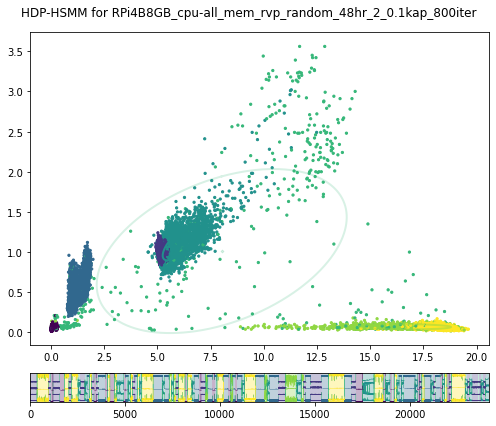

Training for 2 extra states, kappa = 0.1, and iters = 800
.........................  [  25/800,   29.42sec avg, ETA 06:20:02 ]
.........................  [  50/800,   29.73sec avg, ETA 06:11:40 ]
.........................  [  75/800,   29.75sec avg, ETA 05:59:31 ]
.........................  [ 100/800,   29.76sec avg, ETA 05:47:15 ]
.........................  [ 125/800,   29.76sec avg, ETA 05:34:47 ]
.........................  [ 150/800,   29.75sec avg, ETA 05:22:20 ]
.........................  [ 175/800,   29.75sec avg, ETA 05:09:51 ]
.........................  [ 200/800,   29.72sec avg, ETA 04:57:12 ]
.........................  [ 225/800,   29.69sec avg, ETA 04:44:32 ]
.........................  [ 250/800,   29.67sec avg, ETA 04:31:59 ]
.........................  [ 275/800,   29.68sec avg, ETA 04:19:42 ]
.........................  [ 300/800,   29.68sec avg, ETA 04:07:19 ]
.........................  [ 325/800,   29.71sec avg, ETA 03:55:11 ]
.........................  [ 350/800,   29.72

In [11]:
"""Generates HSMM Model using Grid Search"""
model, state_sequences, true_labels, states = SM.grid_search([2], [0.1,0.1,0.1,0.1], [800], "don't save fig")

In [12]:
labeled_data_train['predicted'] = state_sequences[0]

In [13]:
"""Training"""
Labels = {}
Accuracies = []

for name,group in labeled_data_train.groupby('state'):
    print(name)
    label = labeled_data_train.groupby('state').get_group(name)['predicted'].value_counts(normalize=True)
    print(label)
    Labels[name] = label.idxmax()
    Accuracies.append(label.max())

augmented_reality
0    0.987266
5    0.012503
6    0.000232
Name: predicted, dtype: float64
game
4    0.988611
5    0.011219
0    0.000170
Name: predicted, dtype: float64
idle
6    0.97878
5    0.02122
Name: predicted, dtype: float64
mining
2    0.776837
3    0.195023
5    0.028009
0    0.000130
Name: predicted, dtype: float64
stream
1    0.947168
5    0.052832
Name: predicted, dtype: float64


In [14]:
labeled_data_train['label'] = labeled_data_train['state'].map(Labels)
labeled_data_test['label'] = labeled_data_test['state'].map(Labels)
#create rolling window for prediction evaluations
for pw in prediction_windows: 
    labeled_data_test[f'label - {pw} step'] = [list(map(int,window.to_list())) for window in labeled_data_test['label'].rolling(window=pw)]
    labeled_data_test[f'label - {pw} step'] = labeled_data_test[f'label - {pw} step'].shift(1-pw)

In [15]:
test_name = data_name
labeled_data_train.to_csv(f"data/{device_name}_{freq}MHz_res_usage_data_train_pred_{test_name}.csv")

In [16]:
"""Prepares test data, predictions start after lookback period"""
prediction_start = lookback
test_labels = labeled_data_test['state'].values
df = labeled_data_test[features]

In [17]:
"""Generates Label Predictions"""
prediction_windows = [1,2,5,10,15,30,60]

for prediction_window in prediction_windows:

    predicted_observations_list, observations_list = [], []
    predicted_stateseq_list = []
    test_labels_window_list = []
    log_likelihoods_list = []

    print(f"{prediction_window}-step prediction")

    for i in tqdm(range(prediction_start,len(labeled_data_test)+1)):
        
        seed_start_idx =  i - lookback
        seed_end_idx = seed_start_idx + lookback
        
        if seed_end_idx > len(labeled_data_test)-prediction_window:
            break
        
        predicted_observations, predicted_stateseq, log_likelihood = SM.HSMM_pred(model,seed_start_idx, seed_end_idx, prediction_window)
        
        predicted_observations_list.append(predicted_observations[lookback:].tolist())
        predicted_stateseq_list.append(predicted_stateseq[lookback:].tolist())
        log_likelihoods_list.append(round(log_likelihood,2))
        observations_list.append(df[i:i+prediction_window].values)

        test_labels_window_list.append(test_labels[i:i+prediction_window])  

    # store results
    predicted_stateseq_list = ['lookback']*lookback + predicted_stateseq_list
    log_likelihoods_list = ['lookback']*lookback + log_likelihoods_list


    if len(labeled_data_test) != len(predicted_stateseq_list):
        
        if prediction_window != 1:
            labeled_data_test = labeled_data_test[:-(prediction_window-1)]

    labeled_data_test[f'predicted states - {prediction_window} step'] = predicted_stateseq_list
    labeled_data_test[f'log_likelihood - {prediction_window} step'] = log_likelihoods_list

print("Done!")

1-step prediction


100%|█████████▉| 10067/10068 [06:10<00:00, 27.16it/s]


2-step prediction


100%|█████████▉| 10066/10068 [06:47<00:00, 24.71it/s]


5-step prediction


100%|█████████▉| 10062/10067 [07:19<00:00, 22.90it/s]


10-step prediction


100%|█████████▉| 10053/10063 [07:15<00:00, 23.08it/s]


15-step prediction


100%|█████████▉| 10039/10054 [07:33<00:00, 22.13it/s]


30-step prediction


100%|█████████▉| 10010/10040 [08:21<00:01, 19.96it/s]


60-step prediction


 99%|█████████▉| 9951/10011 [09:55<00:03, 16.70it/s]

Done!


In [18]:
"""Testing"""
for name,group in labeled_data_test.groupby('state'):
    print(name)
    print(labeled_data_test[lookback:].groupby('state').get_group(name)[f'predicted states - {1} step'].value_counts(normalize=True))

augmented_reality
[0]    0.947075
[5]    0.044104
[4]    0.004178
[1]    0.001857
[3]    0.000929
[6]    0.000929
[2]    0.000929
Name: predicted states - 1 step, dtype: float64
game
[4]    0.915388
[5]    0.032004
[2]    0.016221
[0]    0.010083
[6]    0.010083
[1]    0.009206
[3]    0.007014
Name: predicted states - 1 step, dtype: float64
idle
[6]    0.876955
[5]    0.112096
[2]    0.003650
[0]    0.002607
[3]    0.002086
[4]    0.001564
[1]    0.001043
Name: predicted states - 1 step, dtype: float64
mining
[2]    0.758333
[3]    0.164583
[5]    0.054167
[6]    0.013542
[1]    0.004167
[4]    0.003125
[0]    0.002083
Name: predicted states - 1 step, dtype: float64
stream
[1]    0.912813
[5]    0.062926
[4]    0.011751
[3]    0.003412
[2]    0.003412
[0]    0.003412
[6]    0.002274
Name: predicted states - 1 step, dtype: float64


In [19]:
"""Save test predictons"""
test_name = data_name
labeled_data_test.to_csv(f"data/{device_name}_{freq}MHz_res_usage_data_test_pred_{test_name}.csv")

In [20]:
"""remove lookback section"""
labeled_data_test = labeled_data_test[lookback:]

1 step prediction accuracy: 89.9%
1 step confusion matrix: 
augmented_reality
Recall 99.5
Specificity 94.71
Precision 98.55
F1 0.99
idle
Recall 99.45
Specificity 87.7
Precision 97.13
F1 0.98
game
Recall 99.4
Specificity 91.54
Precision 97.53
F1 0.98
stream
Recall 99.58
Specificity 91.28
Precision 96.94
F1 0.98
mining
Recall 99.39
Specificity 75.83
Precision 97.47
F1 0.98


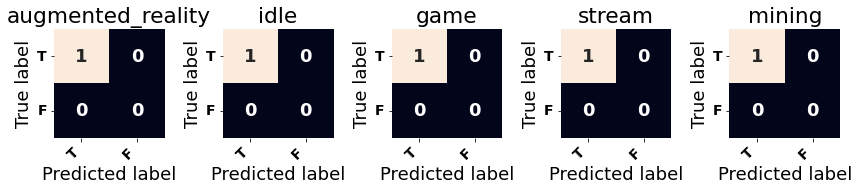

Steps 1 - MA Window 100
{'game': 'salmon', 'augmented_reality': 'lightblue', 'idle': 'lightgreen', 'mining': 'peachpuff', 'stream': 'whitesmoke'}


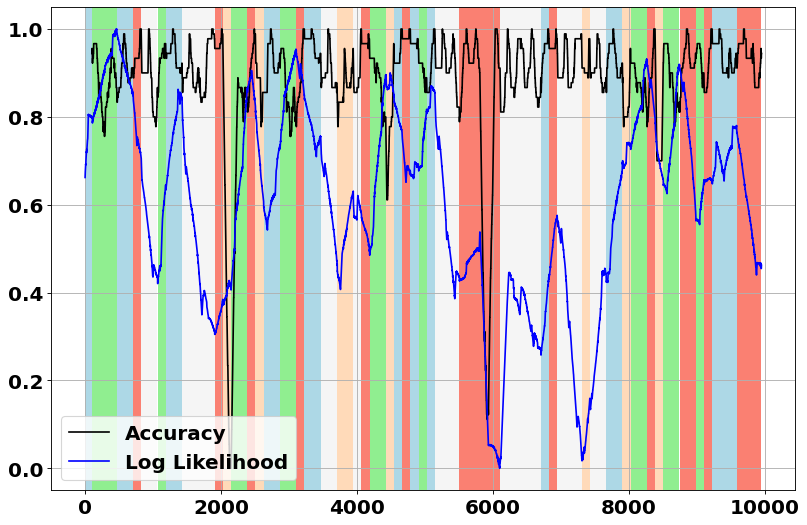

2 step prediction accuracy: 87.85%
2 step confusion matrix: 
augmented_reality
Recall 99.22
Specificity 92.48
Precision 97.95
F1 0.99
idle
Recall 99.28
Specificity 83.86
Precision 96.26
F1 0.98
game
Recall 98.89
Specificity 90.6
Precision 97.25
F1 0.98
stream
Recall 99.54
Specificity 88.95
Precision 96.15
F1 0.98
mining
Recall 99.16
Specificity 75.89
Precision 97.47
F1 0.98


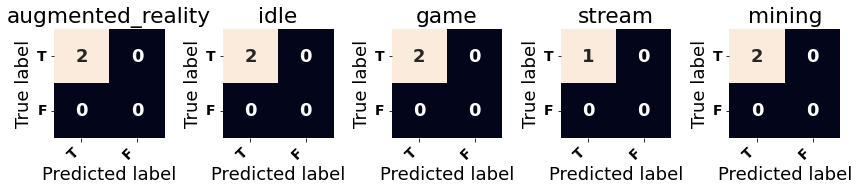

Steps 2 - MA Window 100
{'game': 'salmon', 'augmented_reality': 'lightblue', 'idle': 'lightgreen', 'mining': 'peachpuff', 'stream': 'whitesmoke'}


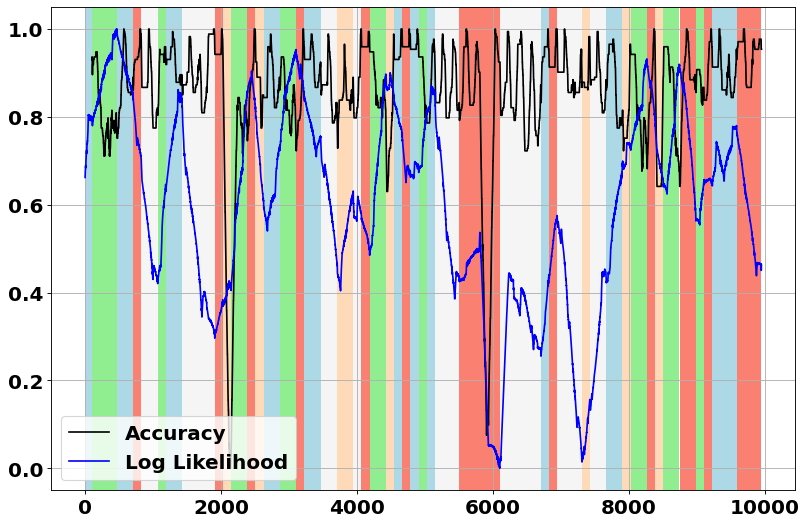

5 step prediction accuracy: 82.56%
5 step confusion matrix: 
augmented_reality
Recall 98.47
Specificity 89.15
Precision 97.04
F1 0.98
idle
Recall 98.85
Specificity 73.56
Precision 94.0
F1 0.96
game
Recall 97.48
Specificity 87.43
Precision 96.31
F1 0.97
stream
Recall 98.94
Specificity 83.15
Precision 94.21
F1 0.97
mining
Recall 98.19
Specificity 72.58
Precision 97.1
F1 0.98


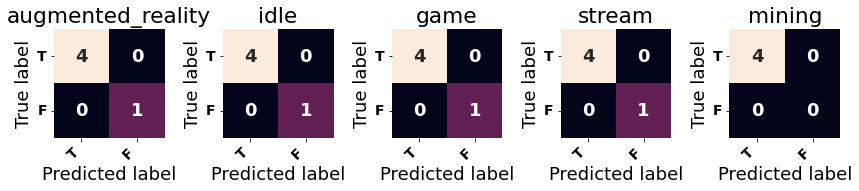

Steps 5 - MA Window 100
{'game': 'salmon', 'augmented_reality': 'lightblue', 'idle': 'lightgreen', 'mining': 'peachpuff', 'stream': 'whitesmoke'}


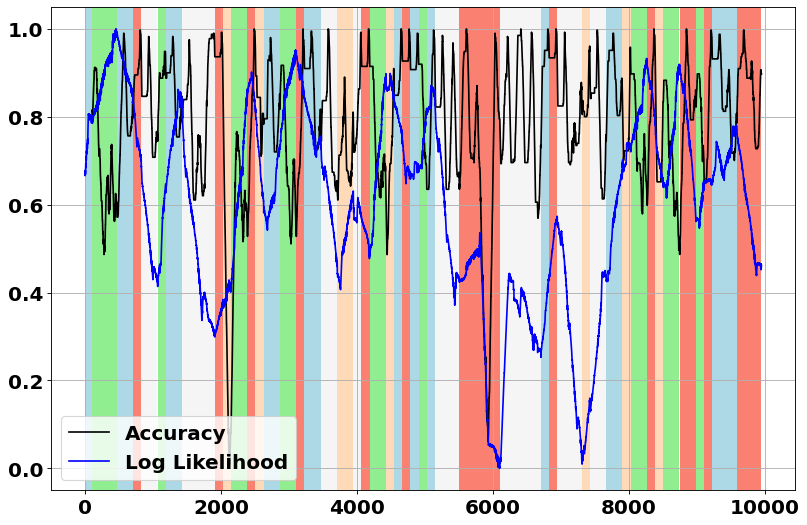

10 step prediction accuracy: 77.48%
10 step confusion matrix: 
augmented_reality
Recall 97.04
Specificity 84.28
Precision 95.72
F1 0.96
idle
Recall 98.21
Specificity 64.9
Precision 92.14
F1 0.95
game
Recall 95.69
Specificity 83.85
Precision 95.22
F1 0.95
stream
Recall 97.72
Specificity 77.59
Precision 92.36
F1 0.95
mining
Recall 96.42
Specificity 71.96
Precision 96.99
F1 0.97


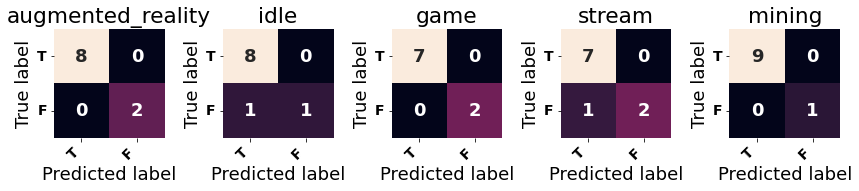

Steps 10 - MA Window 100
{'game': 'salmon', 'augmented_reality': 'lightblue', 'idle': 'lightgreen', 'mining': 'peachpuff', 'stream': 'whitesmoke'}


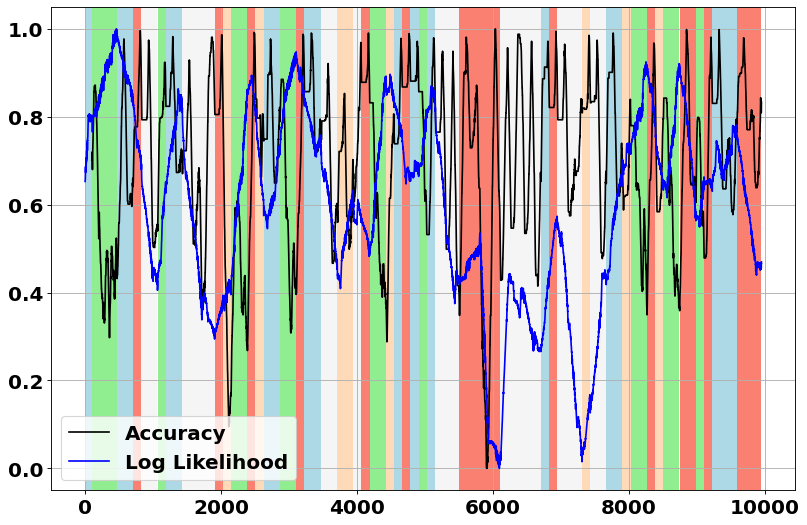

15 step prediction accuracy: 73.02%
15 step confusion matrix: 
augmented_reality
Recall 96.2
Specificity 79.22
Precision 94.37
F1 0.95
idle
Recall 97.42
Specificity 58.0
Precision 90.67
F1 0.94
game
Recall 93.89
Specificity 80.07
Precision 94.06
F1 0.94
stream
Recall 97.1
Specificity 74.49
Precision 91.34
F1 0.94
mining
Recall 94.85
Specificity 68.35
Precision 96.56
F1 0.96


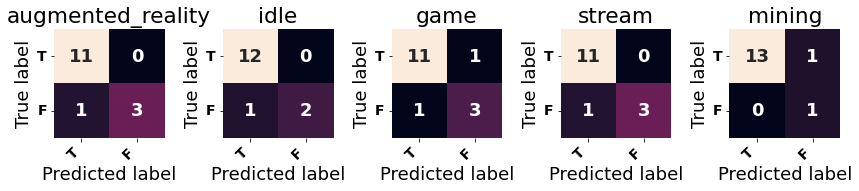

Steps 15 - MA Window 100
{'game': 'salmon', 'augmented_reality': 'lightblue', 'idle': 'lightgreen', 'mining': 'peachpuff', 'stream': 'whitesmoke'}


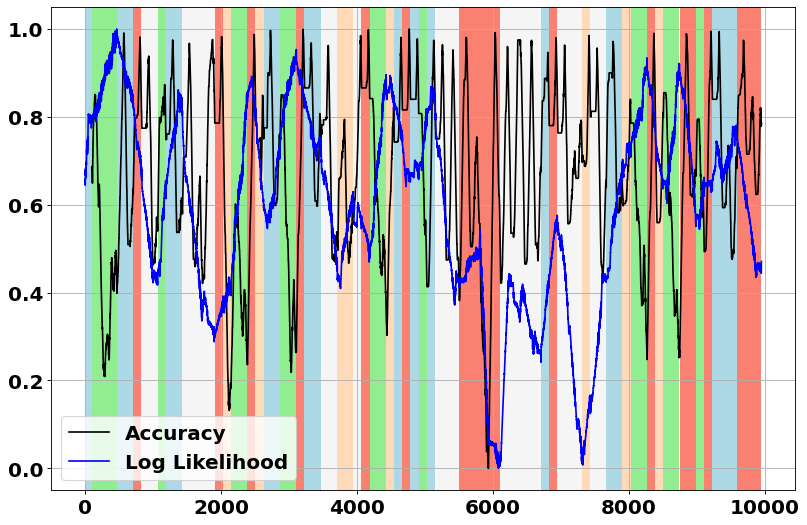

30 step prediction accuracy: 65.18%
30 step confusion matrix: 
augmented_reality
Recall 94.04
Specificity 71.63
Precision 92.31
F1 0.93
idle
Recall 96.26
Specificity 46.47
Precision 88.28
F1 0.92
game
Recall 91.18
Specificity 74.22
Precision 92.24
F1 0.92
stream
Recall 95.35
Specificity 65.86
Precision 88.56
F1 0.92
mining
Recall 92.83
Specificity 64.71
Precision 96.1
F1 0.94


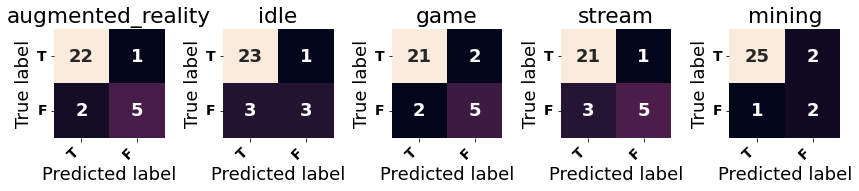

Steps 30 - MA Window 100
{'game': 'salmon', 'augmented_reality': 'lightblue', 'idle': 'lightgreen', 'mining': 'peachpuff', 'stream': 'whitesmoke'}


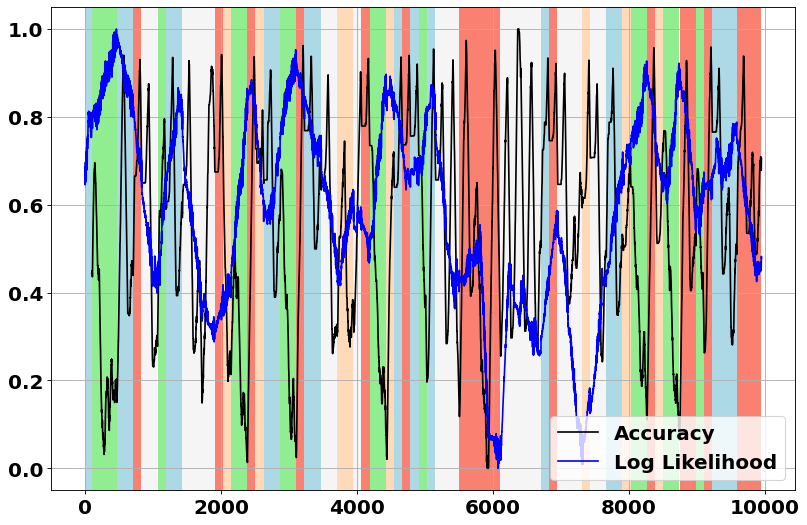

60 step prediction accuracy: 53.47%
60 step confusion matrix: 
augmented_reality
Recall 91.53
Specificity 59.28
Precision 89.05
F1 0.9
idle
Recall 94.71
Specificity 32.84
Precision 85.52
F1 0.9
game
Recall 87.38
Specificity 64.34
Precision 89.18
F1 0.88
stream
Recall 92.6
Specificity 52.93
Precision 84.51
F1 0.88
mining
Recall 87.41
Specificity 57.3
Precision 95.04
F1 0.91


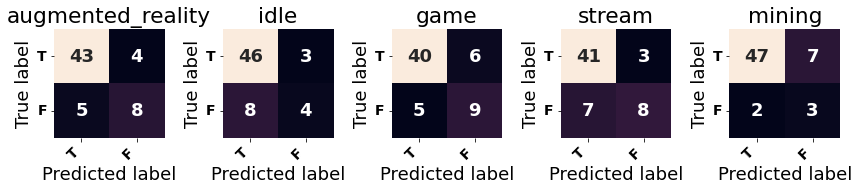

Steps 60 - MA Window 100
{'game': 'salmon', 'augmented_reality': 'lightblue', 'idle': 'lightgreen', 'mining': 'peachpuff', 'stream': 'whitesmoke'}


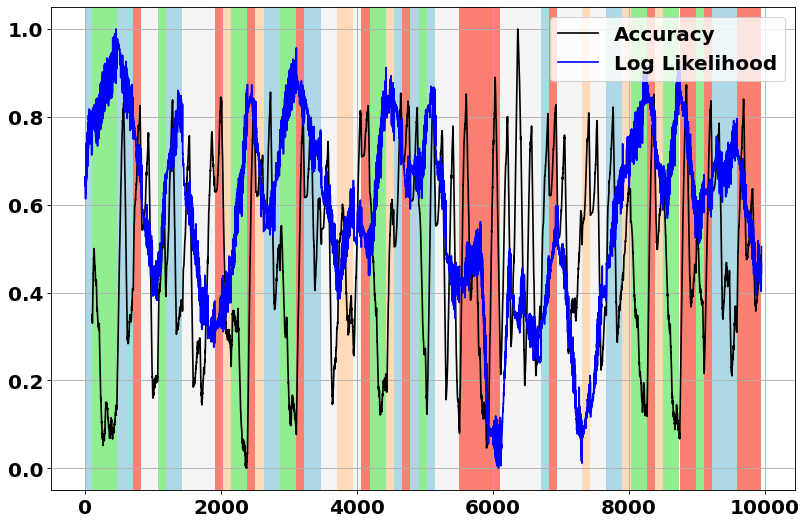

In [21]:
"""Analysis of Predictions"""

plt.rc('font', **{'weight' : 'bold', 'size'   : 18})

for prediction_window in prediction_windows:
    accuracy, conf_matrix = [], []
    for index, row in labeled_data_test.iterrows():
        accuracy.append(accuracy_score(row[f'label - {prediction_window} step'], row[f'predicted states - {prediction_window} step'])*100)
        conf_matrix.append(multilabel_confusion_matrix(row[f'label - {prediction_window} step'], row[f'predicted states - {prediction_window} step'], labels=labeled_data_test['label'].unique().tolist()))

    labeled_data_test[f'accuracy - {prediction_window} step'] = accuracy
    labeled_data_test[f'confusion matrix - {prediction_window} step'] = conf_matrix
   

    print(f"{prediction_window} step prediction accuracy: {round(mean(accuracy),2)}%")
    print(f"{prediction_window} step confusion matrix: ")

    SM.classification_report(conf_matrix, labeled_data_test['state'].unique().tolist())

    SM.plot_accuracy_likelihood(prediction_window, 100)